In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/Users/rdgao/Documents/code/research/spectralCV')
sys.path.append('/Users/rdgao/Documents/code/research/neurodsp/')


# imports
import os
import numpy as np
import scipy as sp
import scipy.io as io
import matplotlib.pyplot as plt

import neurodsp as ndsp
from scv_funcs import lfpca

### Data preprocessing
Spectrogram is computed in two ways: whole-recording and trial-epoched. 
- For whole-recording (all), spectrogram is computed as normal, i.e. non-overlaping sliding window.
- For trial-epoched, 1-second of data immediately preceding (pre) and following (move) the onset of movement is grabbed, and a PSD is computed (effectively Hamming windowed FFT). Trial type information (which finger) and whether there was trial overlap during both pre and move period is stored.

### Conditions to include a trial:
1. there is a movement-free period of at least *alpha* proportion of length *L_win* before the cue onset
2. there is a movement period of at least *alpha* proportion of length *L_win* after movement onset
3. there is a maximum lag of *L_lag* between trial onset and movement onset

In [2]:
def get_trial_info(cue_sig, move_sig, L_win=1000, L_lag=2000, alpha=0.95):
    # stim_info vector: [trial onset, movement onset, trial type, RT, premove duration, move duration]
    trial_init = np.where(np.diff((cue_sig>0).astype(int))==1)[0]+1
    move_init = np.where(np.diff((move_sig>0).astype(int))==1)[0]+1 
    trial_info = []
    for i, tr_onset in enumerate(trial_init):
        # pre-movement length
        L_premove = np.sum(move_sig[tr_onset-L_win:tr_onset]<=0)    
        # find corresponding movement onset time
        try:
            # if this fails, it means there was no response on the last trial
            mv_onset = move_init[np.where(move_init>tr_onset)[0][0]]        
            L_move = np.sum(move_sig[mv_onset:mv_onset+L_win]>0)
            # if 3 conditions are satisfied, add trial
            if L_premove/L_win>alpha and L_move/L_win>alpha and (mv_onset-tr_onset)<L_lag:
                RT = mv_onset-tr_onset
                trial_info.append([tr_onset, mv_onset, move_sig[mv_onset], RT, L_premove, L_move])
        except:
            print('Skipped last trial.')
    return np.array(trial_info)

def lfpca_kjm(data_path, subj, fs, analysis_param):
    # load data & trial info
    stim_info = io.loadmat(data_path+'data/'+subj+'/'+subj+'_stim.mat', squeeze_me=True)
    data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
    ecog = data['data'].T
    
    # set parameters
    win_len = int(fs)
    num_chan = ecog.shape[0]
    max_freq = analysis_param['max_freq']
    
    # sort out trial info
    trial_info = get_trial_info(data['cue'], stim_info['stim'], L_win=win_len, L_lag=1500, alpha=0.9)
    num_trials = trial_info.shape[0]
    print('%i included trials.'%num_trials)
        
    if num_trials>20:
        # pre-initialize arrays
        psd_precomp = np.zeros((num_chan, max_freq, num_trials, 2))

        # precompute trial PSDs
        for tr in range(num_trials):
            tr_onset = trial_info[tr,0]
            mv_onset = trial_info[tr,1]
            # pre-movement
            f_axis, p_ = ndsp.spectral.psd(ecog[:,tr_onset-win_len:tr_onset], Fs=fs, nperseg=win_len)        
            psd_precomp[:,:,tr,0] = p_[:,:max_freq]
            # movement
            f_axis, p_ = ndsp.spectral.psd(ecog[:,mv_onset:mv_onset+win_len], Fs=fs, nperseg=win_len)
            psd_precomp[:,:,tr,1] = p_[:,:max_freq]

        lfpca_all = []
        for i in range(2):
            mov_lfpca = lfpca.LFPCA(analysis_param)
            mov_lfpca.populate_fourier_data(psd_precomp[:,:,:,i], fs, f_axis)
            mov_lfpca.compute_psd()
            mov_lfpca.compute_scv()
            lfpca_all.append(mov_lfpca)

        # return the pre- and during-movement lfpca data, and trial info
        return lfpca_all, trial_info
    else:
        return None, None

wc


(120000, 180000)

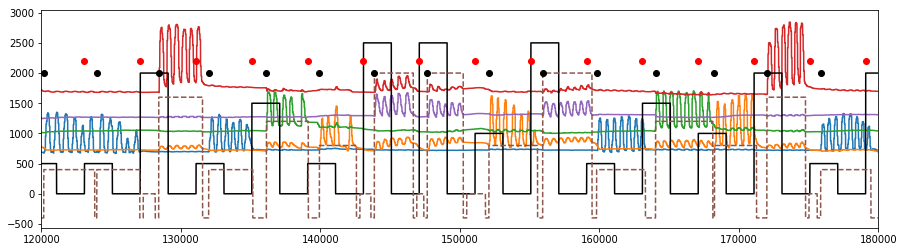

In [93]:
# subj = subjs[6]
# print(subj)
# stim_info = io.loadmat(data_path+'data/'+subj+'/'+subj+'_stim.mat', squeeze_me=True)
# data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
# plot_inds = range(0,len(data['cue']))
# plt.figure(figsize=(15,4))
# plt.plot(data['flex'][plot_inds,0:])
# plt.plot(data['cue'][plot_inds]*500, 'k')
# plt.plot(stim_info['stim'][plot_inds]*400, '--')
# move_init = np.where(np.diff((stim_info['stim']>0).astype(int))==1)[0]+1
# trial_init = np.where(np.diff((data['cue']>0).astype(int))==1)[0]+1
# plt.plot(trial_init,np.ones_like(trial_init)*2200, 'or')
# plt.plot(move_init,np.ones_like(move_init)*2000, 'ok')
# plt.xlim([120000, 180000])

In [3]:
# define data folder
data_path = '/Users/rdgao/Documents/data/ECoG_KJM/digit/'
saveout_path = '../results/kjm_digits/'
save_files = ['pre','move','whole']
subjs = ['bp', 'cc', 'ht', 'jc', 'jp', 'mv', 'wc', 'wm', 'zt']

# electrode location
elec_def = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}

In [95]:
fs = 1000.
# lfpca params
analysis_param = {'nperseg': 1000,
                 'noverlap': 0,
                 'spg_outlierpct': 2.,
                 'max_freq':200}

for subj in subjs:
    print(subj)
    # get the trial-separated LFPCA
    lfpca_all, trial_info = lfpca_kjm(data_path,subj,fs,analysis_param)
    if lfpca_all is not None:
        # get LFPCA for whole recording
        data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)    
        lfpca_all.append(lfpca.LFPCA(analysis_param))
        lfpca_all[-1].populate_ts_data(data['data'].T, fs)
        lfpca_all[-1].compute_all_spectral()

        # make dir
        subj_path = saveout_path+subj+'/'
        if not os.path.isdir(subj_path):
            os.mkdir(subj_path)

        print('Computing exponential KS test...')
        for ind, lf in enumerate(lfpca_all):
            # compute fit
            lf.compute_KS_expfit()
            # save out LFPCA         
            lf.save_spec_vars(subj_path+save_files[ind]+'.npz', save_spg=True)

        # save trial info and plot contrast
        np.savez(subj_path+'trial_info.npz', trial_info=trial_info, elec_regions=data['elec_regions'])
    else:
        print('Skipped subject.')

bp
103 included trials.
Computing exponential KS test...
cc
63 included trials.
Computing exponential KS test...
ht
84 included trials.
Computing exponential KS test...
jc
Skipped last trial.
107 included trials.
Computing exponential KS test...
jp
Skipped last trial.
Skipped last trial.
7 included trials.
Skipped subject.
mv
0 included trials.
Skipped subject.
wc
39 included trials.
Computing exponential KS test...
wm
Skipped last trial.
Skipped last trial.
29 included trials.
Computing exponential KS test...
zt
33 included trials.
Computing exponential KS test...


# Fine timescale analysis

In [11]:
subj = subjs[0]
stim_info = io.loadmat(data_path+'data/'+subj+'/'+subj+'_stim.mat', squeeze_me=True)
data = io.loadmat(data_path+'data/'+subj+'/'+subj+'_fingerflex.mat', squeeze_me=True)
ecog = data['data'].T
fs = 1000.

chan = 12
nb_pwr, nb_phz, val_inds, ker_len = lfpca.compute_BP_HT(ecog[chan,:], fs, (35,45))

/Users/rdgao/Documents/code/research/neurodsp/neurodsp/filt.py:78: UserWarning: "f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.
  warnings.warn('"f_lo" or "f_hi" inputs are being deprecated. Use "fc" to specify cutoff frequencies.')
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


275 4447


/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rdgao/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([ 4.,  1.,  4.,  8.,  6.,  7., 13., 18., 10., 14., 20., 27., 26.,
        36., 29., 29., 17., 34., 31., 37., 29., 35., 34., 50., 66., 38.,
        46., 65., 67., 66., 68., 73., 78., 82., 72., 70., 98., 66., 65.,
        76., 77., 90., 98., 73., 76., 88., 77., 84., 73., 79., 71., 60.,
        71., 69., 56., 56., 59., 68., 36., 58., 60., 60., 61., 43., 45.,
        40., 46., 51., 43., 43., 61., 50., 51., 50., 46., 38., 40., 59.,
        27., 54., 46., 37., 50., 30., 42., 33., 29., 30., 22., 31., 19.,
        21.,  7.,  7., 16.,  8.,  6.,  5.,  3.,  2.]),
 array([-6.04834853, -5.92570132, -5.8030541 , -5.68040689, -5.55775967,
        -5.43511246, -5.31246524, -5.18981803, -5.06717081, -4.9445236 ,
        -4.82187638, -4.69922917, -4.57658196, -4.45393474, -4.33128753,
        -4.20864031, -4.0859931 , -3.96334588, -3.84069867, -3.71805145,
        -3.59540424, -3.47275702, -3.35010981, -3.2274626 , -3.10481538,
        -2.98216817, -2.85952095, -2.73687374, -2.61422652, -2.491579

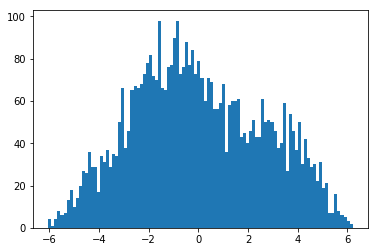

In [86]:
# plt.figure(figsize=(12,3))
# plt.plot(ecog[chan,:])
# plt.plot(nb_pwr/100)
# plt.xlim([0,10000])
chan = 12
nb_pwr, nb_phz, val_inds, ker_len = lfpca.compute_BP_HT(ecog[chan,:], fs, (8,15), N_cycles=7)
skip_len = int(ker_len/2)
print(ker_len, len(val_inds[::skip_len]))
#plt.hist(nb_pwr[val_inds],50)
lfpca.fit_test_exp(nb_pwr[val_inds][::skip_len])
plt.hist(np.diff(nb_phz[val_inds][::skip_len]),100)

### old code below (pre-lfpca)

### spectral PCA

In [7]:
from sklearn.decomposition import PCA

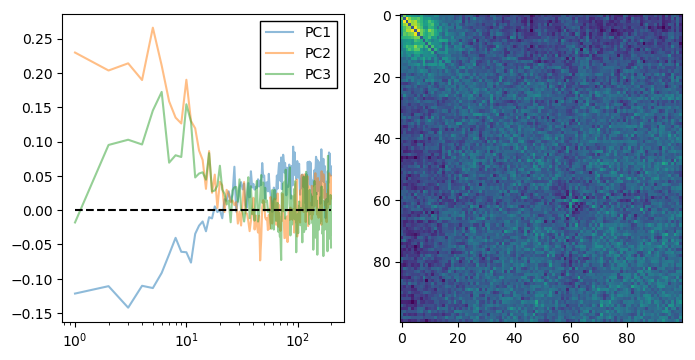

In [33]:
num_freq = 100
chan = 0
f_axis, t_axis, spg = sp.signal.spectrogram(ecog[:,chan], fs=fs, nperseg=int(fs), noverlap=0)
pca = PCA(n_components=3)
pca.fit(np.log10(np.abs(spg**2).T))

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogx(f_axis[1:200],pca.components_[:,1:200].T, alpha=0.5)
plt.plot([1,200], [0,0], 'k--')
plt.legend(('PC1', 'PC2', 'PC3'))

plt.subplot(1,2,2)
plt.imshow(sp.corrcoef(np.log10(np.abs(spg**2)))[:num_freq,:num_freq]*(np.ones((num_freq, num_freq))-np.eye(num_freq)))
#plt.colorbar()